# Lab 4 Final Notebook

In [262]:
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import time
import glob
import tqdm 

import ugradio
import astropy.coordinates
import astropy.time
import astropy.io.fits as fits

## 1. Import noise off and noise on data

In [ ]:
# noise off 
files_off = glob.glob('../Data/celestial_pole-noiseoff_*.fits')
data_noise_off = {}
ra_dec_jd_dict = {}
for filename in files_off:
    d_off = fits.open(filename)
    header = dict(d_off[0].header)
    d_off_avg = np.mean([d_off[j].data['auto0_real'] for j in range(1,21)], axis=0)
    data_noise_off[(int(header['L']), int(header['B']))] = d_off_avg[10:-10]
    ra_dec_jd_dict[(int(header['L']), int(header['B']))] = [int(header['RA']), int(header['DEC']), int(header['JD'])]

Ls = list(set([key[0] for key in data_noise_off.keys()]))
Bs = list(set([key[1] for key in data_noise_off.keys()]))
Ls.sort()
Bs.sort()

grid_off = np.zeros((len(Ls),len(Bs)))
Ls = np.array(Ls)
Bs = np.array(Bs)

for (L,B), spec in data_noise_off.items(): 
    grid_off[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec.max()

In [ ]:
# noise on
data_noise_on = {}
files_on = glob.glob('../Data/celestial_pole-noiseon_*.fits')
for filename in files_on:
    d_on = fits.open(filename)
    header = dict(d_on[0].header)
    d_on_avg = np.mean([d_on[j].data['auto0_real'] for j in range(1,3)], axis=0)
    data_noise_on[(int(header['L']), int(header['B']))] = d_on_avg[10:-10]
    
#data_noise_on
Ls = list(set([key[0] for key in data_noise_on.keys()]))
Bs = list(set([key[1] for key in data_noise_off.keys()]))
Ls.sort()
Bs.sort()
grid_on = np.zeros((len(Ls),len(Bs)))
Ls = np.array(Ls)
Bs = np.array(Bs)

for (L,B), spec in data_noise_off.items(): #items gives you the keys and the values
    grid_on[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec.max()

In [ ]:
plt.figure()
plt.imshow(grid_off, extent=[105,160,50,15])
plt.title("Noise Off Power Spectra")

Text(0.5, 1.0, 'Noise On Power Spectra')

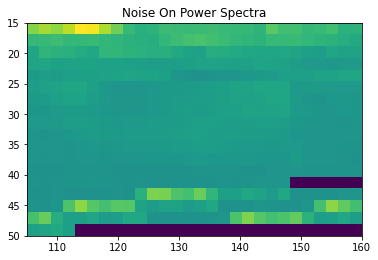

In [5]:
plt.figure()
plt.imshow(grid_on, extent=[105,160,50,15])
plt.title("Noise On Power Spectra")

## 2. Get Frequency Array and Plot 

In [6]:
data_noise_off_example = fits.open('../Data/celestial_pole-noiseoff_' + str(0) + '.fits')
hdr = dict(data_noise_off_example[0].header)
if_freq = 144 + np.arange(0, hdr['NCHAN']) * hdr['RES'] / 1e6
rf_freq = if_freq + 2*635
rf_freq = rf_freq[10:-10]

In [7]:
hydrogen_freq = rf_freq[4373]

<IPython.core.display.Javascript object>


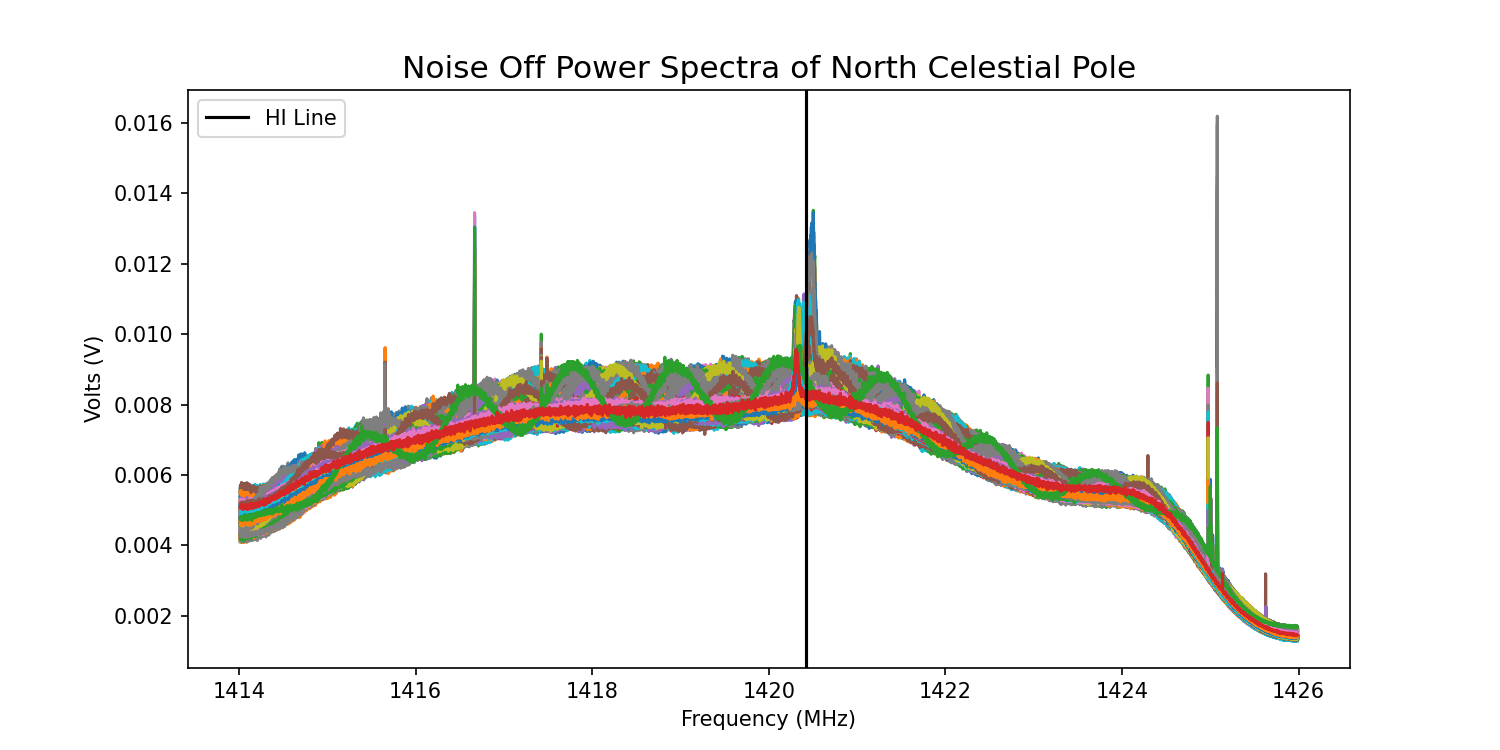

In [24]:
%matplotlib notebook
plt.figure(figsize=(10,5))
for i in data_noise_off:
    plt.plot(rf_freq, data_noise_off[i])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
#plt.xlim(1419.85, 1421)
plt.axvline(rf_freq[4373], color='black', label='HI Line')
#plt.axvline(rf_freq[4283], color='r', label='Red Shift Bound')
#plt.axvline(rf_freq[4473], color='b', label='Blue Shift Bound')
plt.title('Noise Off Power Spectra of North Celestial Pole', fontsize=15)
plt.legend()

<IPython.core.display.Javascript object>


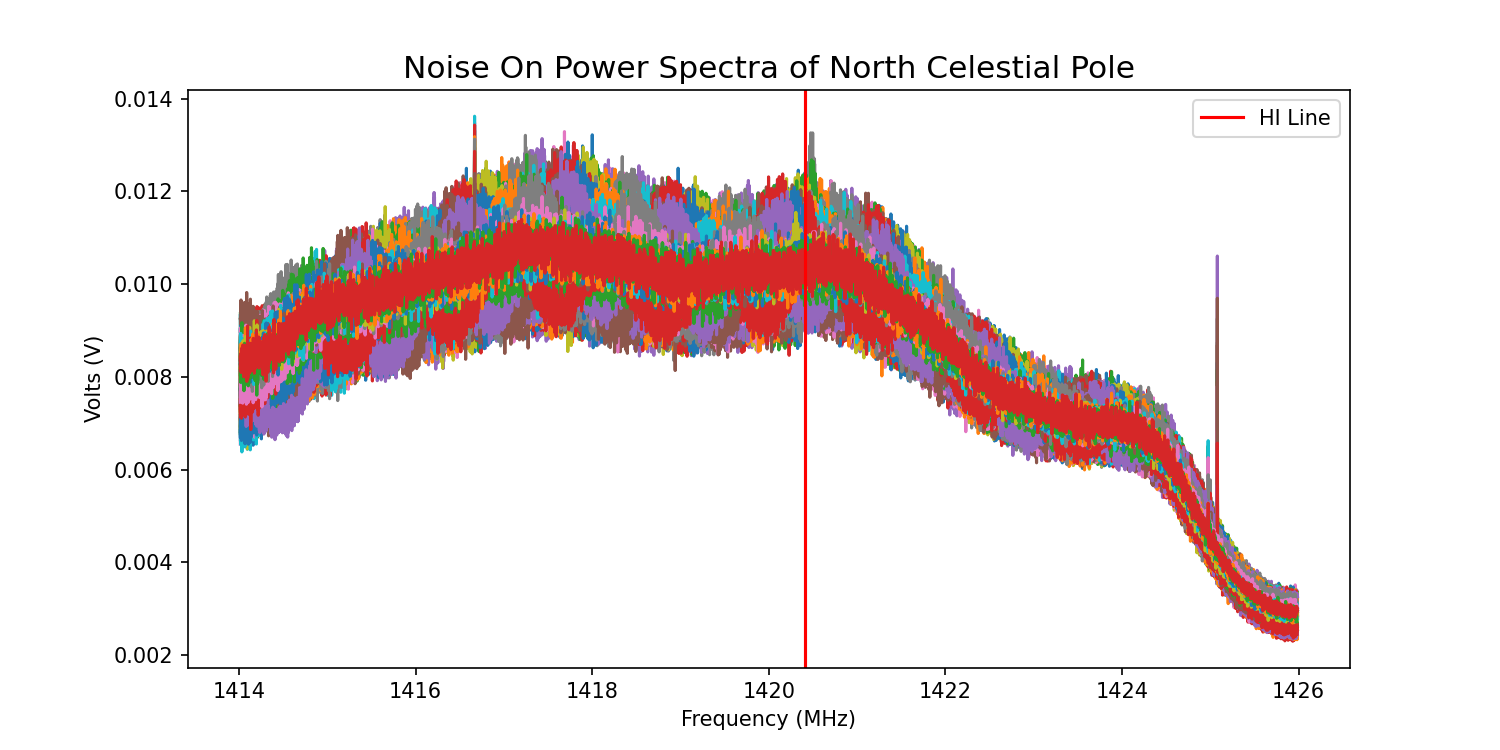

In [25]:
%matplotlib notebook
plt.figure(figsize=(10,5))

for i in data_noise_on:
    plt.plot(rf_freq, data_noise_on[i])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
plt.axvline(1420.405, color='r', label='HI Line')
plt.title('Noise On Power Spectra of North Celestial Pole', fontsize=15)
plt.legend()

## 3. Calibrate Spectra

<IPython.core.display.Javascript object>


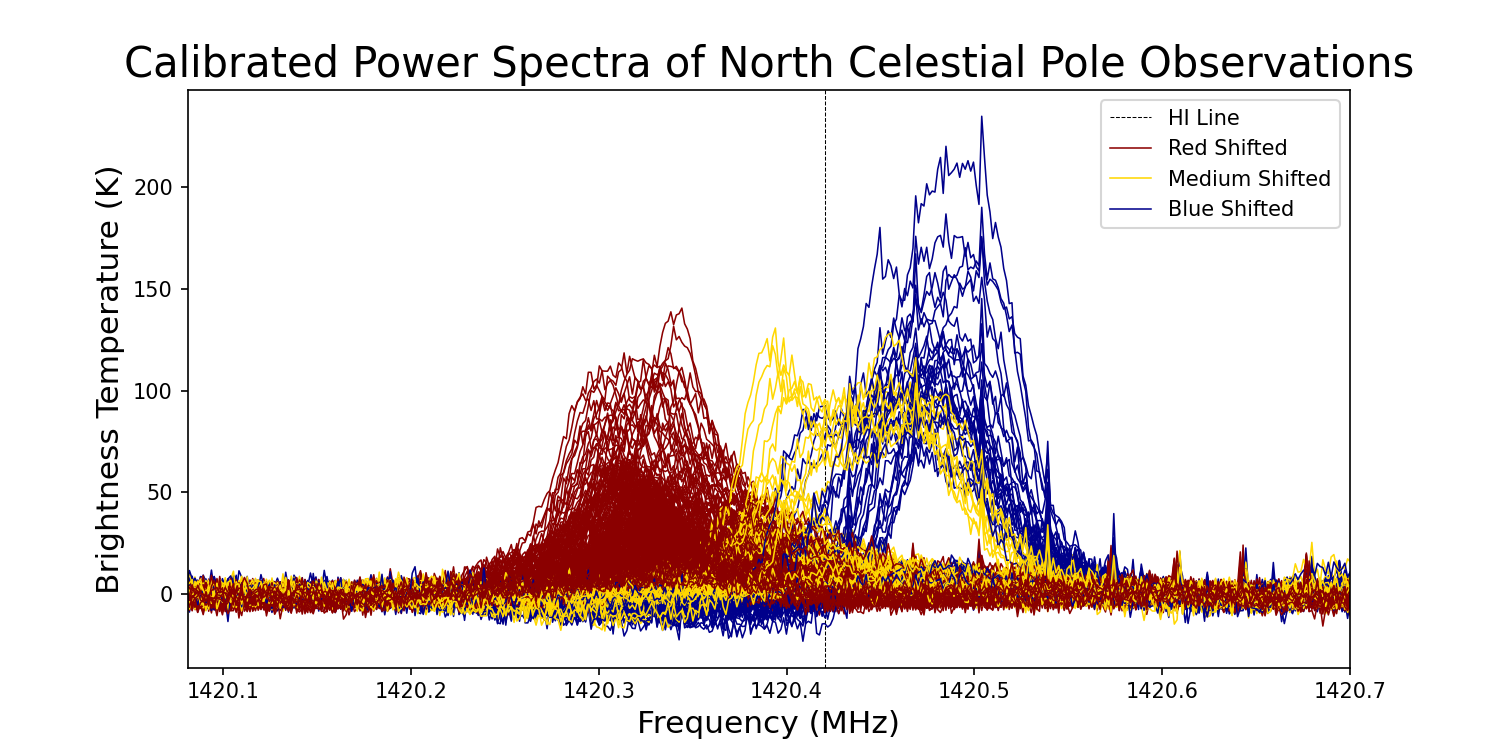

(1420.081, 1420.7)

In [26]:
%matplotlib notebook

t_noise = 90
t_sys = 2.5

plt.figure(figsize=(10,5))
plt.xlabel('Frequency (MHz)', fontsize=15)
plt.ylabel('Brightness Temperature (K)', fontsize=15)
plt.title('Calibrated Power Spectra of North Celestial Pole Observations', fontsize=20)
calibrated_noise_off_dictionary = {}
calibrated_red_dictionary = {}
calibrated_blue_dictionary = {}
red_blue_dictionary = {}
calibrated_noise_off_list = []

plt.axvline(rf_freq[4373], color='black', label='HI Line', linestyle='--', linewidth=.5)
#plt.axvline(rf_freq[4263], color='r', label='Red Shift Bound')
#plt.axvline(rf_freq[4473], color='b', label='Blue Shift Bound')
#plt.axvline(rf_freq[4345], color='yellow', label='Medium Shift Bound')
#plt.axvline(rf_freq[4400], color='yellow')
first_blue = True
first_red = True
first_yellow = True
for i in data_noise_off:
    g = (t_noise - t_sys) / np.sum(data_noise_on[i] - data_noise_off[i]) * np.sum(data_noise_on[i])

    s_line = data_noise_off[i]/(np.mean(data_noise_off[i][3000:4000])) #~8000 data points, don't include peak in avg
    
    #line = np.concatenate(s_line[4000:4270],s_line[4470:5000])
    
    index = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4650]))[0]
    
    filt_freq = rf_freq[index]
    filt_power = s_line[index]
    
    ind_left = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4270]))[0] 
    ind_right = np.where((rf_freq > rf_freq[4470]) & (rf_freq < rf_freq[4650]))[0]
    
    inds = np.hstack([ind_left, ind_right])
    
    p = np.polyfit(rf_freq[inds], s_line[inds], 7)
    
    fit = np.polyval(p, rf_freq[index])
    
    calibrated_spectra = g*(s_line[index] - fit)
    peak_freq = filt_freq[list(calibrated_spectra).index(np.max(calibrated_spectra))]
    
    if peak_freq >= rf_freq[4345] and peak_freq < rf_freq[4400] and first_yellow:
        plt.plot(rf_freq[index], calibrated_spectra, 'gold', linewidth=.75, label='Medium Shifted')
        red_blue_dictionary[i] = .5
        first_yellow = False
    
    elif peak_freq >= rf_freq[4345] and peak_freq < rf_freq[4400]:
        plt.plot(rf_freq[index], calibrated_spectra, 'gold', linewidth=.75)
        red_blue_dictionary[i] = .5
        
    elif peak_freq <= rf_freq[4373] and peak_freq > rf_freq[4263] and first_red:
        plt.plot(rf_freq[index], calibrated_spectra, 'darkred', linewidth=.75, label='Red Shifted') #off
        calibrated_red_dictionary[i] = calibrated_spectra
        red_blue_dictionary[i] = 0
        first_red = False
        
    elif peak_freq <= rf_freq[4373] and peak_freq > rf_freq[4263]:
        plt.plot(rf_freq[index], calibrated_spectra, 'darkred', linewidth=.75)
        calibrated_red_dictionary[i] = calibrated_spectra
        red_blue_dictionary[i] = 0
        
    elif peak_freq >= rf_freq[4373] and peak_freq < rf_freq[4473] and first_blue:
        plt.plot(rf_freq[index], calibrated_spectra, 'darkblue', linewidth=.75, label='Blue Shifted') #off
        first_blue = False
        calibrated_blue_dictionary[i] = calibrated_spectra
        red_blue_dictionary[i] = 1
        
    elif peak_freq >= rf_freq[4373] and peak_freq < rf_freq[4473]:
        plt.plot(rf_freq[index], calibrated_spectra, 'darkblue', linewidth=.75) #off
        calibrated_blue_dictionary[i] = calibrated_spectra
        red_blue_dictionary[i] = 1
    
    calibrated_noise_off_dictionary[i] = calibrated_spectra
    calibrated_noise_off_list.append(calibrated_spectra)
plt.legend(fontsize=10)
plt.ticklabel_format(style='plain', scilimits=None, useOffset=False, useLocale=None, useMathText=None)
plt.xlim(1420.081, 1420.7)

## 4. All Shifted : Create Dictionaries of Grid Values

In [223]:
# all shifted 
f_0 = 1420.4e6 #Hz
c = 3e8 #m/s
k = 1.381e-23 #1.381e-16 cgs
nu_0 = 1420.405e6 #hz #hydrogen rest freq
nu = []
c = 3e8 #m/s

power_dict = {}
intensity_dict = {}
column_density_dict = {}
doppler_velocity_dict = {}

for i in tqdm.tqdm(calibrated_noise_off_dictionary):
    #spectra already in temperature from calibrated
    #power = np.sum(spectra) #not meaningful, be careful, keep things in temp units. Take an average
    #power = np.mean(spectra[4270 : 4470])# fix this later # do different slices 
    
    spectra = calibrated_noise_off_dictionary[i]
    power = np.mean(spectra[270:470])
    power_dict[i] = power

    #spectra_index = list(spectra).index(max(spectra))
    freq = rf_freq[index]*1e6 #[spectra_index]*1e6 #so it's in hertz
    #brightness_temp = spectra[spectra_index]
    intensity = spectra*2*k*freq**2/(c**2)
    
    #intensity = 2*freq**2*(1.381e-23)*brightness_temp/(c**2)# c is in seconds
    intensity_dict[i] = intensity
    
    v = freq*c/(2*f_0) *1e2 # doppler velocity, convert to cm/s
    delta_v = np.median(v[1:]-v[:-1]) #np.diff(v)
    column_density = abs(spectra)* delta_v * 1.8e18
    column_density_dict[i] = np.sum(column_density)
    
    spectra_index = list(spectra).index(max(spectra))
    new_freq = freq[spectra_index]
    delta_nu = new_freq - nu_0
    vel = delta_nu * c / nu_0
    ra = ra_dec_jd_dict[i][0]
    dec = ra_dec_jd_dict[i][1]
    jd = ra_dec_jd_dict[i][2]
    lsr_vel = ugradio.doppler.get_projected_velocity(ra, dec, jd)
    
    velocity = vel - abs(lsr_vel.value)
    doppler_velocity_dict[i] = velocity/1000 #km/s

100%|██████████| 474/474 [00:57<00:00,  8.22it/s]


In [224]:
# create grids
power_grid = np.zeros((len(Ls),len(Bs)))
power_grid[:,] = np.nan
intensity_grid = np.zeros((len(Ls),len(Bs)))
intensity_grid[:,] = np.nan
column_density_grid = np.zeros((len(Ls),len(Bs)))
column_density_grid[:,] = np.nan
doppler_velocity_grid = np.zeros((len(Ls),len(Bs)))
doppler_velocity_grid[:,] = np.nan
red_blue_grid = np.zeros((len(Ls),len(Bs)))
red_blue_grid[:,] = np.nan

for (L,B), spec in power_dict.items(): #items gives you the keys and the values
    power_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec

for (L,B), spec in intensity_dict.items(): #items gives you the keys and the values
    intensity_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec.max() #gives you a list of lists
    
for (L,B), spec in column_density_dict.items(): #items gives you the keys and the values
    column_density_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec.max() #gives you a list of lists
    
for (L,B), spec in doppler_velocity_dict.items(): #items gives you the keys and the values
    doppler_velocity_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec #gives you a list of lists
    
for (L,B), spec in red_blue_dictionary.items(): #items gives you the keys and the values
    red_blue_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec #gives you a list of lists

<IPython.core.display.Javascript object>


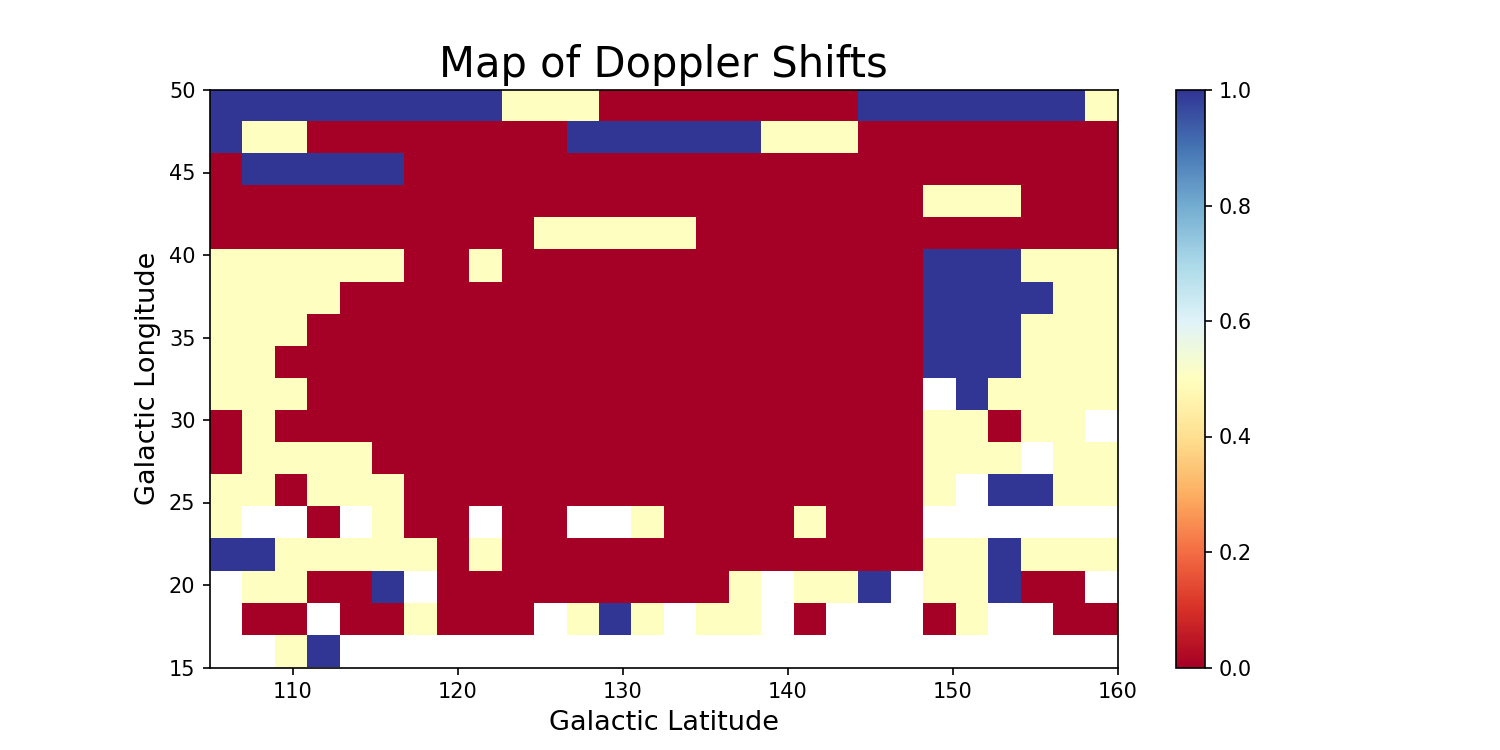

Text(0, 0.5, 'Galactic Longitude')

In [225]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.imshow(red_blue_grid, extent=[105,160,15,50], cmap='RdYlBu')
plt.colorbar()
plt.title('Map of Doppler Shifts', fontsize=20)
plt.xlabel('Galactic Latitude', fontsize=13)
plt.ylabel('Galactic Longitude', fontsize=13)

<IPython.core.display.Javascript object>


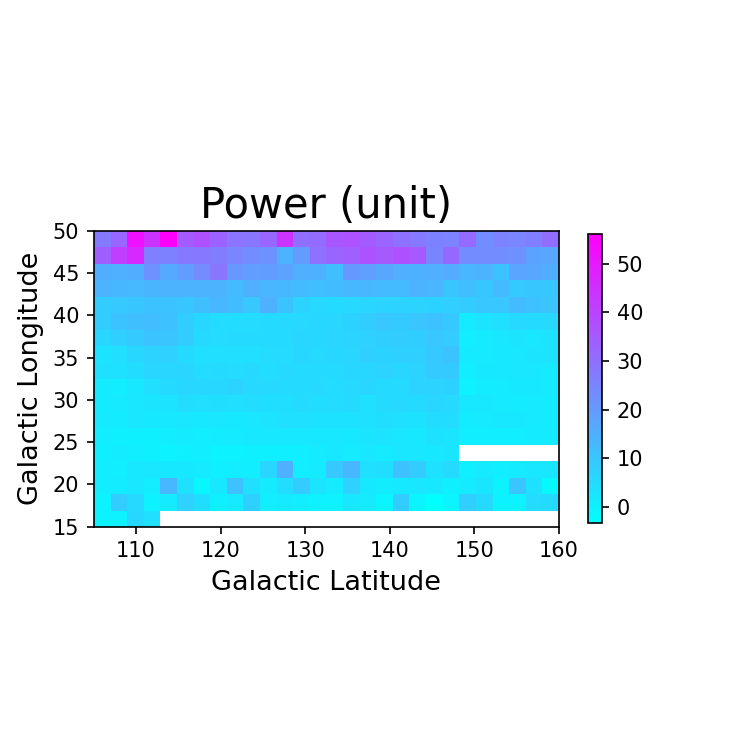

Text(0, 0.5, 'Galactic Longitude')

In [227]:
%matplotlib notebook
plt.figure(figsize=(5,5))
plt.imshow(power_grid, extent=[105,160,15,50], cmap='cool')
plt.colorbar(shrink=.5)
plt.title('Power (unit)', fontsize=20)
plt.xlabel('Galactic Latitude', fontsize=13)
plt.ylabel('Galactic Longitude', fontsize=13)

<IPython.core.display.Javascript object>


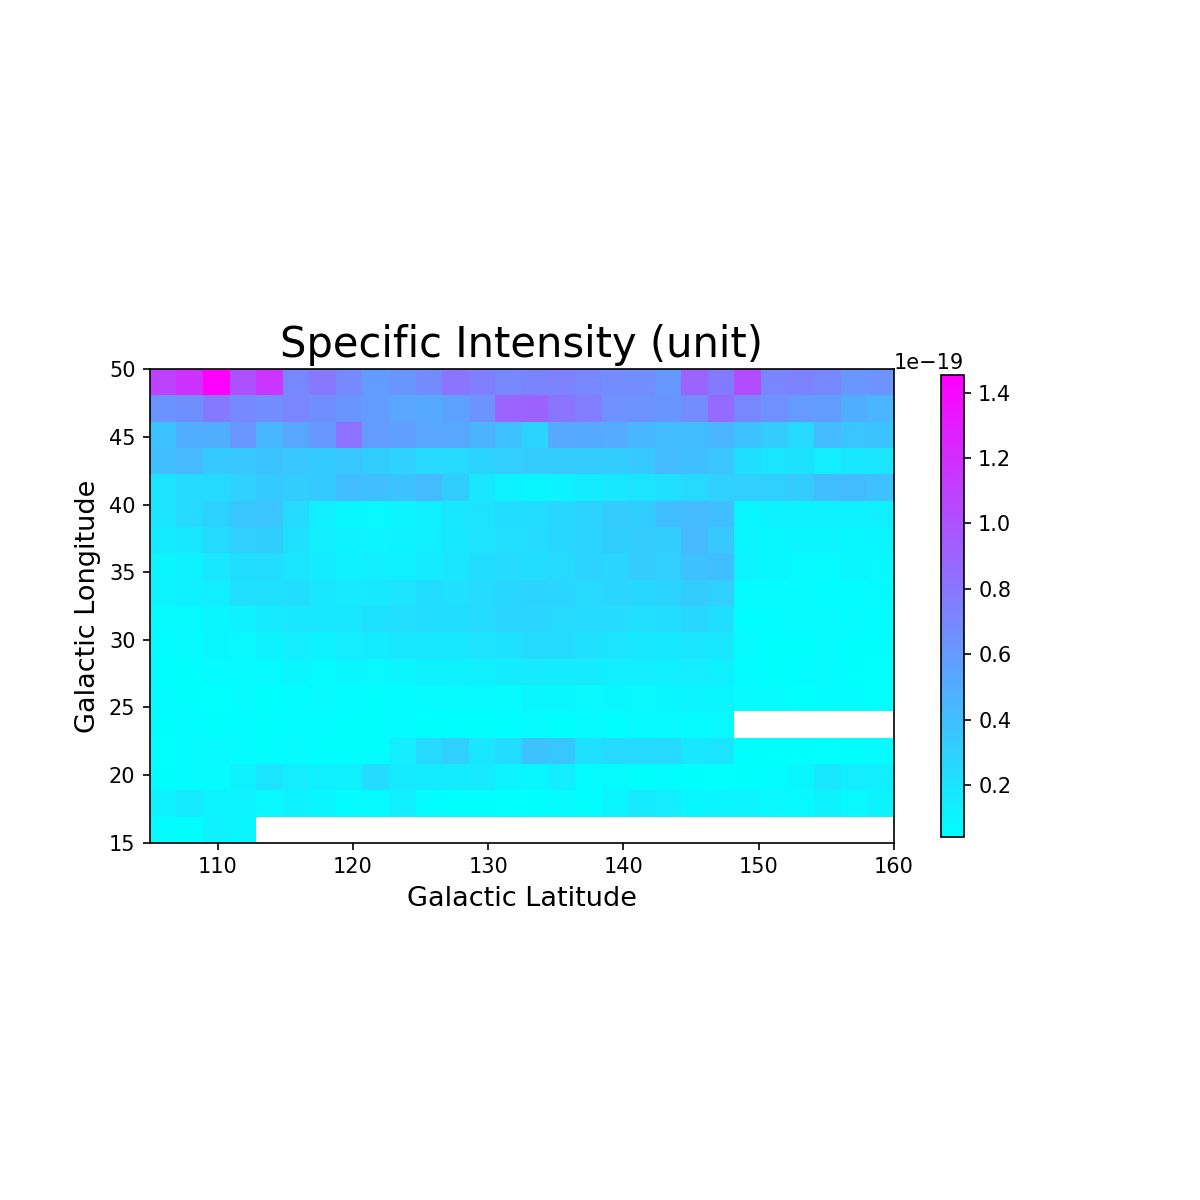

Text(0, 0.5, 'Galactic Longitude')

In [111]:
%matplotlib notebook
plt.figure(figsize=(8,8))
plt.imshow(intensity_grid, extent=[105,160,15,50], cmap='cool')
plt.colorbar(shrink=.5)
plt.title('Specific Intensity (unit)', fontsize=20)
plt.xlabel('Galactic Latitude', fontsize=13)
plt.ylabel('Galactic Longitude', fontsize=13)

<IPython.core.display.Javascript object>


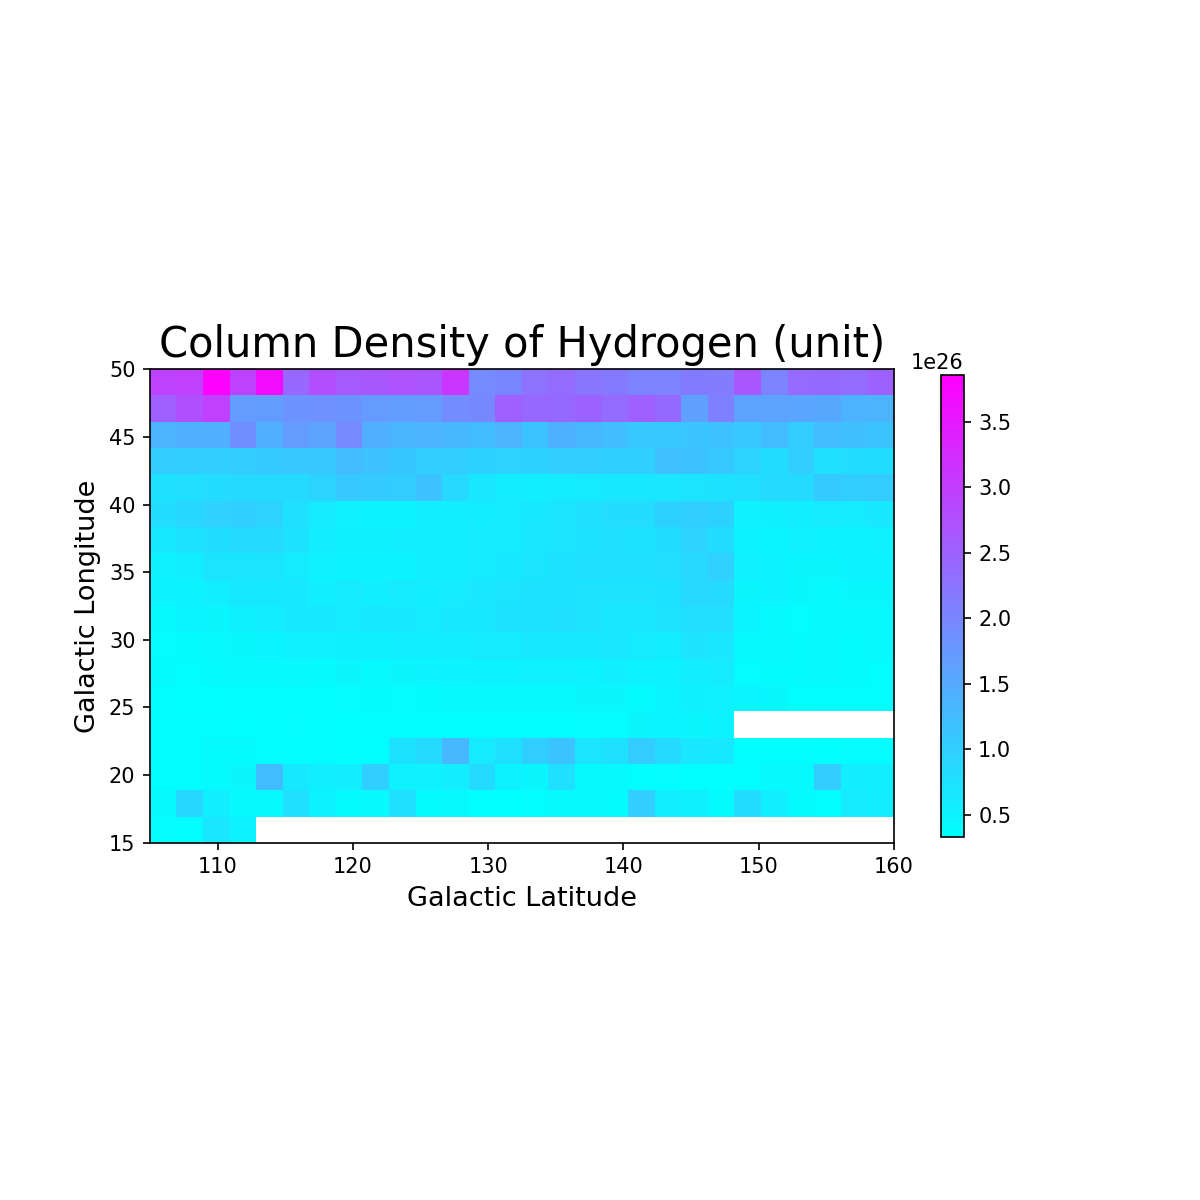

Text(0, 0.5, 'Galactic Longitude')

In [112]:
%matplotlib notebook
plt.figure(figsize=(8,8))
plt.imshow(column_density_grid, extent=[105,160,15,50], cmap='cool')
plt.colorbar(shrink=.5)
plt.title('Column Density of Hydrogen (unit)', fontsize=20)
plt.xlabel('Galactic Latitude', fontsize=13)
plt.ylabel('Galactic Longitude', fontsize=13)

<IPython.core.display.Javascript object>


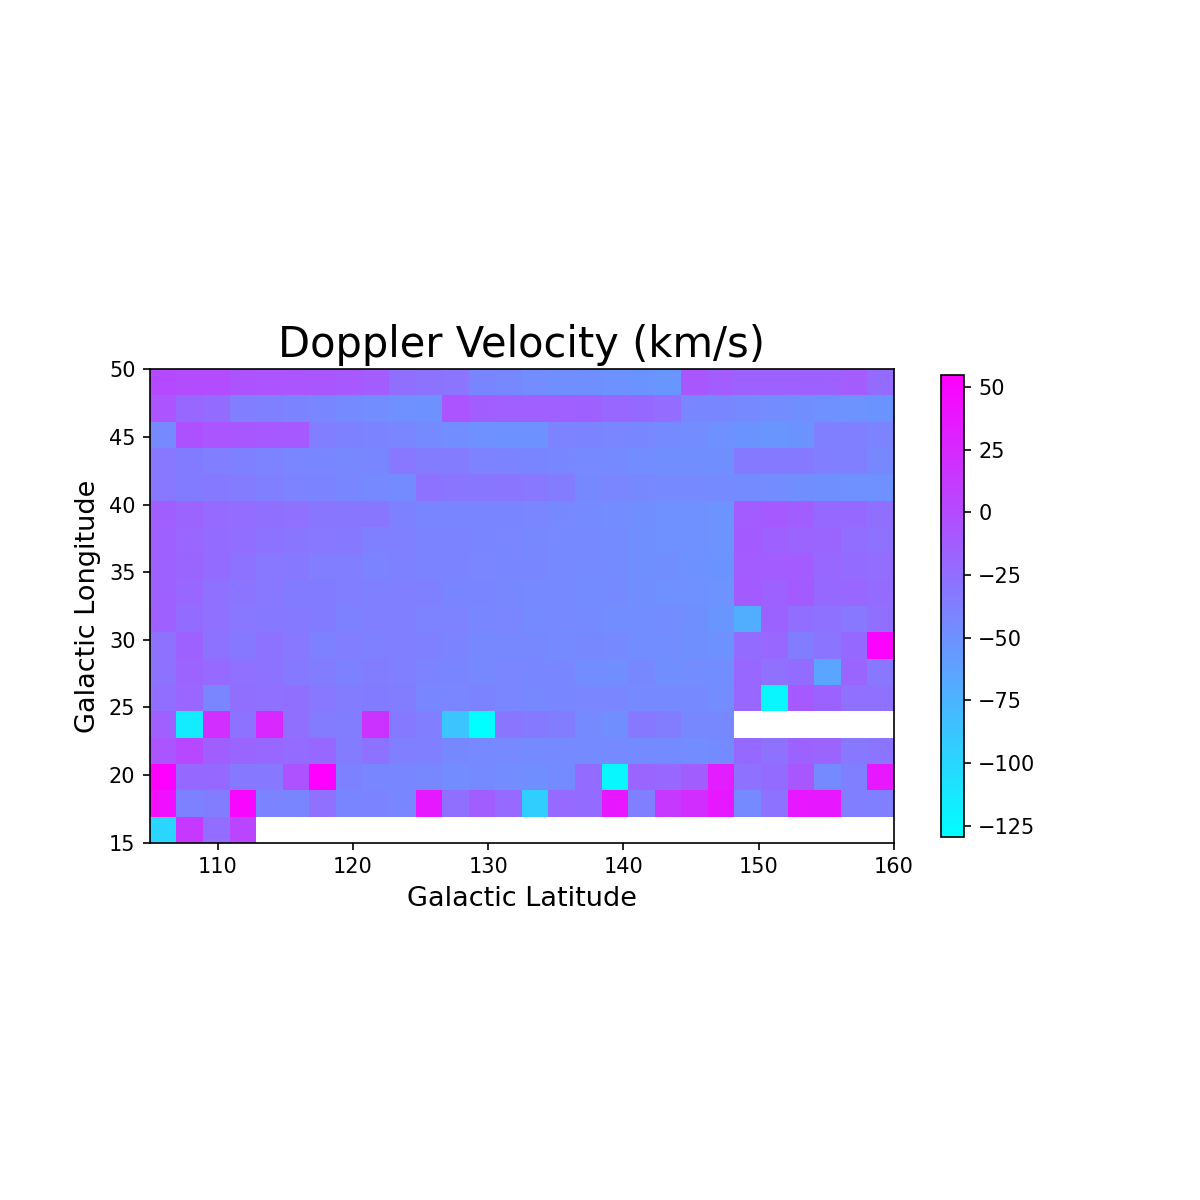

Text(0, 0.5, 'Galactic Longitude')

In [245]:
%matplotlib notebook
plt.figure(figsize=(8,8))
plt.imshow(doppler_velocity_grid, extent=[105,160,15,50], cmap='cool')
plt.colorbar(shrink=.5)
plt.title('Doppler Velocity (km/s)', fontsize=20)
plt.xlabel('Galactic Latitude', fontsize=13)
plt.ylabel('Galactic Longitude', fontsize=13)

## 5. Blue Shifted : Create Dictionaries of Grid Values

In [114]:
# blueshifted 
f_0 = 1420.4e6 #Hz
c = 3e8 #m/s
k = 1.381e-23 #1.381e-16 cgs
nu_0 = 1420.405e6 #Mhz #hydrogen rest freq
nu = []
c = 3e8 #m/s

blue_power_dict = {}
blue_intensity_dict = {}
blue_column_density_dict = {}
blue_doppler_velocity_dict = {}

for i in calibrated_blue_dictionary:
    #spectra already in temperature from calibrated
    #power = np.sum(spectra) #not meaningful, be careful, keep things in temp units. Take an average
    #power = np.mean(spectra[4270 : 4470])# fix this later # do different slices 
    
    spectra = calibrated_blue_dictionary[i]
    power = np.mean(spectra)
    blue_power_dict[i] = power

    #spectra_index = list(spectra).index(max(spectra))
    freq = rf_freq[index]*1e6 #[spectra_index]*1e6 #so it's in hertz
    #brightness_temp = spectra[spectra_index]
    intensity = spectra*2*k*freq**2/(c**2)
    
    #intensity = 2*freq**2*(1.381e-23)*brightness_temp/(c**2)# c is in seconds
    blue_intensity_dict[i] = intensity
    
    v = freq*c/(2*f_0) *1e2 # doppler velocity, convert to cm/s
    delta_v = np.median(v[1:]-v[:-1]) #np.diff(v)
    column_density = abs(spectra)* delta_v * 1.8e18
    
    blue_column_density_dict[i] = np.sum(column_density)
    
    spectra_index = list(spectra).index(max(spectra))
    new_freq = freq[spectra_index]
    delta_nu = new_freq - nu_0
    vel = delta_nu * c / nu_0
    ra = ra_dec_jd_dict[i][0]
    dec = ra_dec_jd_dict[i][1]
    jd = ra_dec_jd_dict[i][2]
    lsr_vel = ugradio.doppler.get_projected_velocity(ra, dec, jd)
    velocity = vel - np.abs(lsr_vel.value)
    blue_doppler_velocity_dict[i] = abs(velocity/1000)

In [115]:
# create grids
blue_power_grid = np.zeros((len(Ls),len(Bs)))
blue_power_grid[:,] = np.nan
blue_intensity_grid = np.zeros((len(Ls),len(Bs)))
blue_intensity_grid[:,] = np.nan
blue_column_density_grid = np.zeros((len(Ls),len(Bs)))
blue_column_density_grid[:,] = np.nan
blue_doppler_velocity_grid = np.zeros((len(Ls),len(Bs)))
blue_doppler_velocity_grid[:,] = np.nan

for (L,B), spec in blue_power_dict.items(): #items gives you the keys and the values
    blue_power_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec

for (L,B), spec in blue_intensity_dict.items(): #items gives you the keys and the values
    blue_intensity_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec.max() #gives you a list of lists
    
for (L,B), spec in blue_column_density_dict.items(): #items gives you the keys and the values
    blue_column_density_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec.max() #gives you a list of lists
    
for (L,B), spec in blue_doppler_velocity_dict.items(): #items gives you the keys and the values
    blue_doppler_velocity_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec #gives you a list of lists

<IPython.core.display.Javascript object>


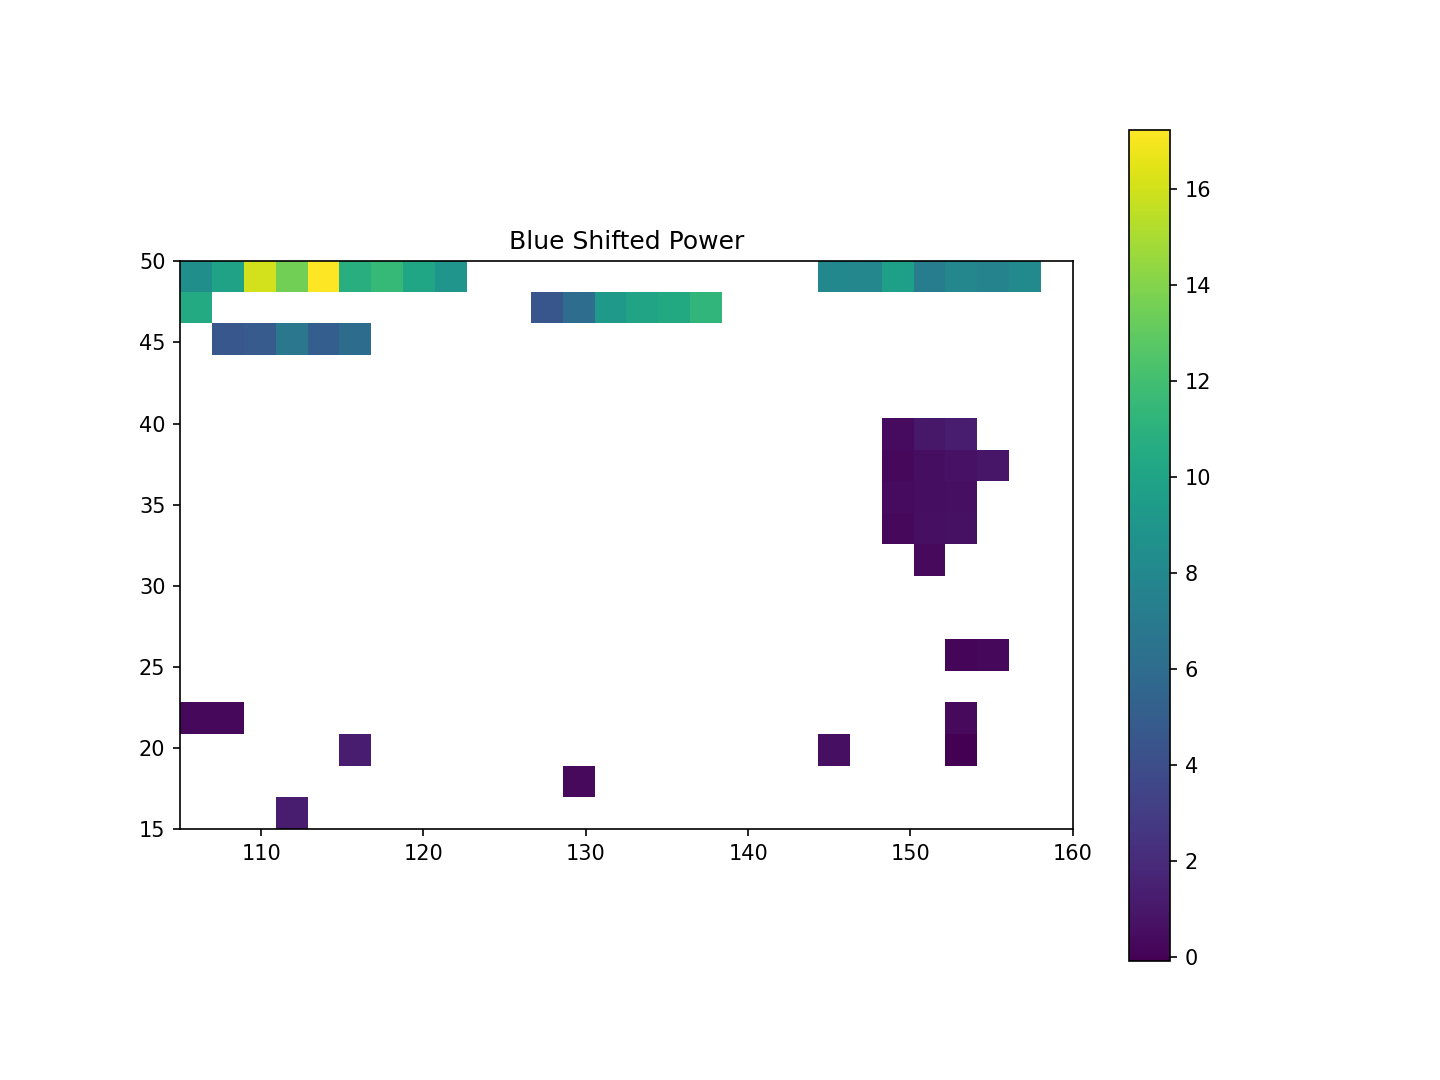

<IPython.core.display.Javascript object>


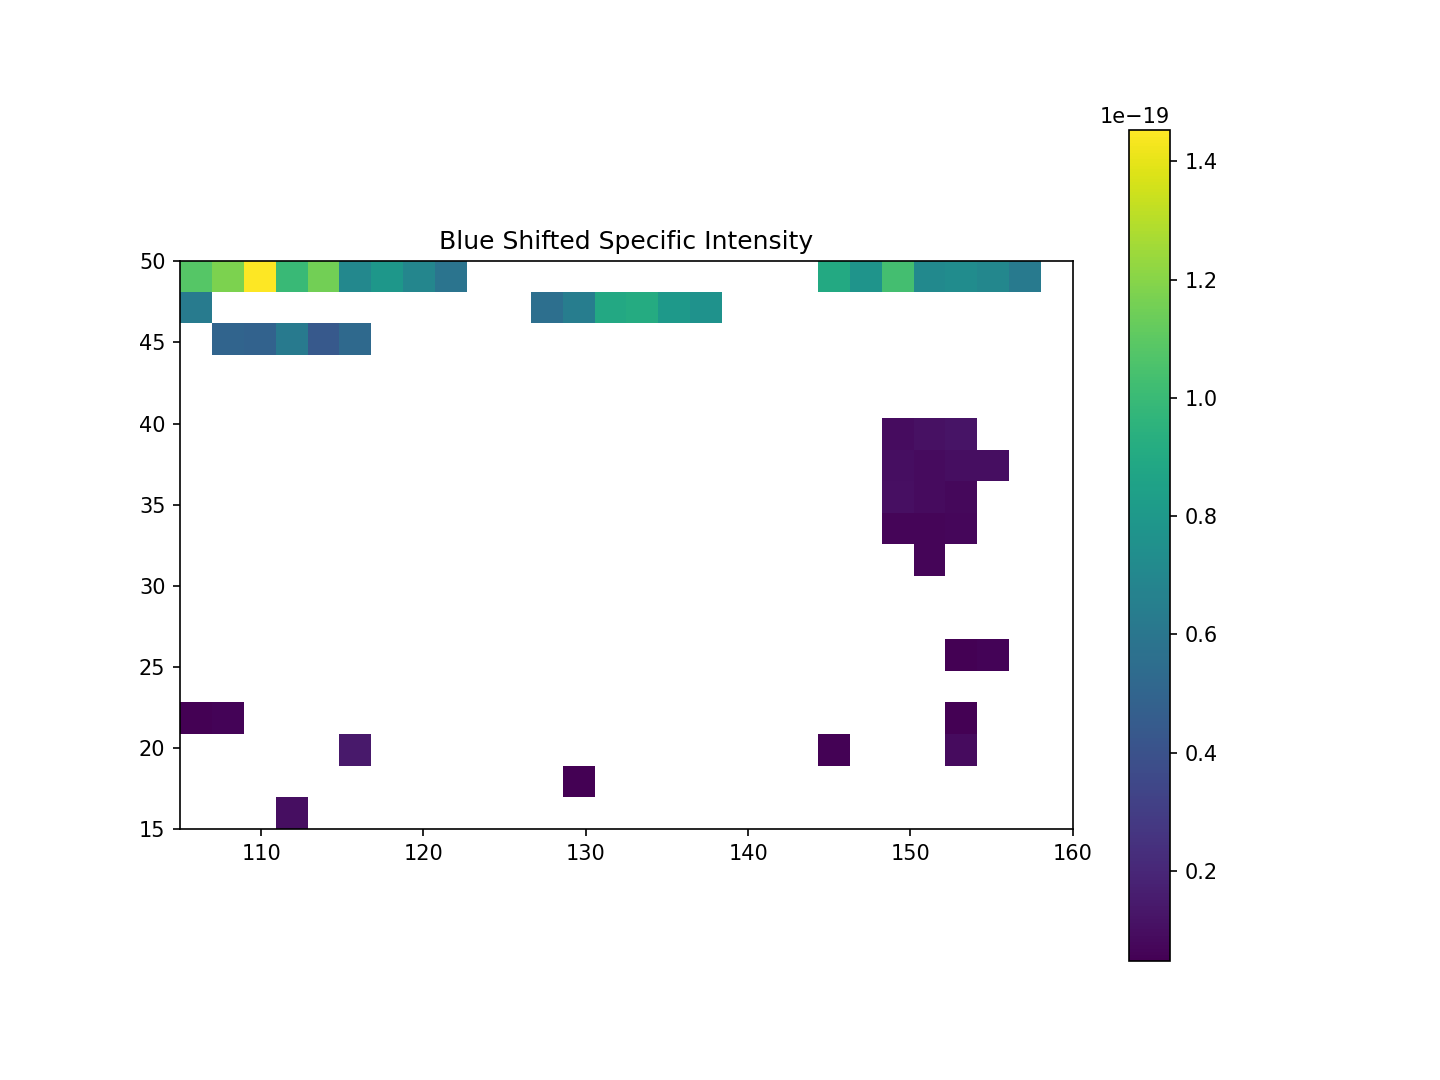

<IPython.core.display.Javascript object>


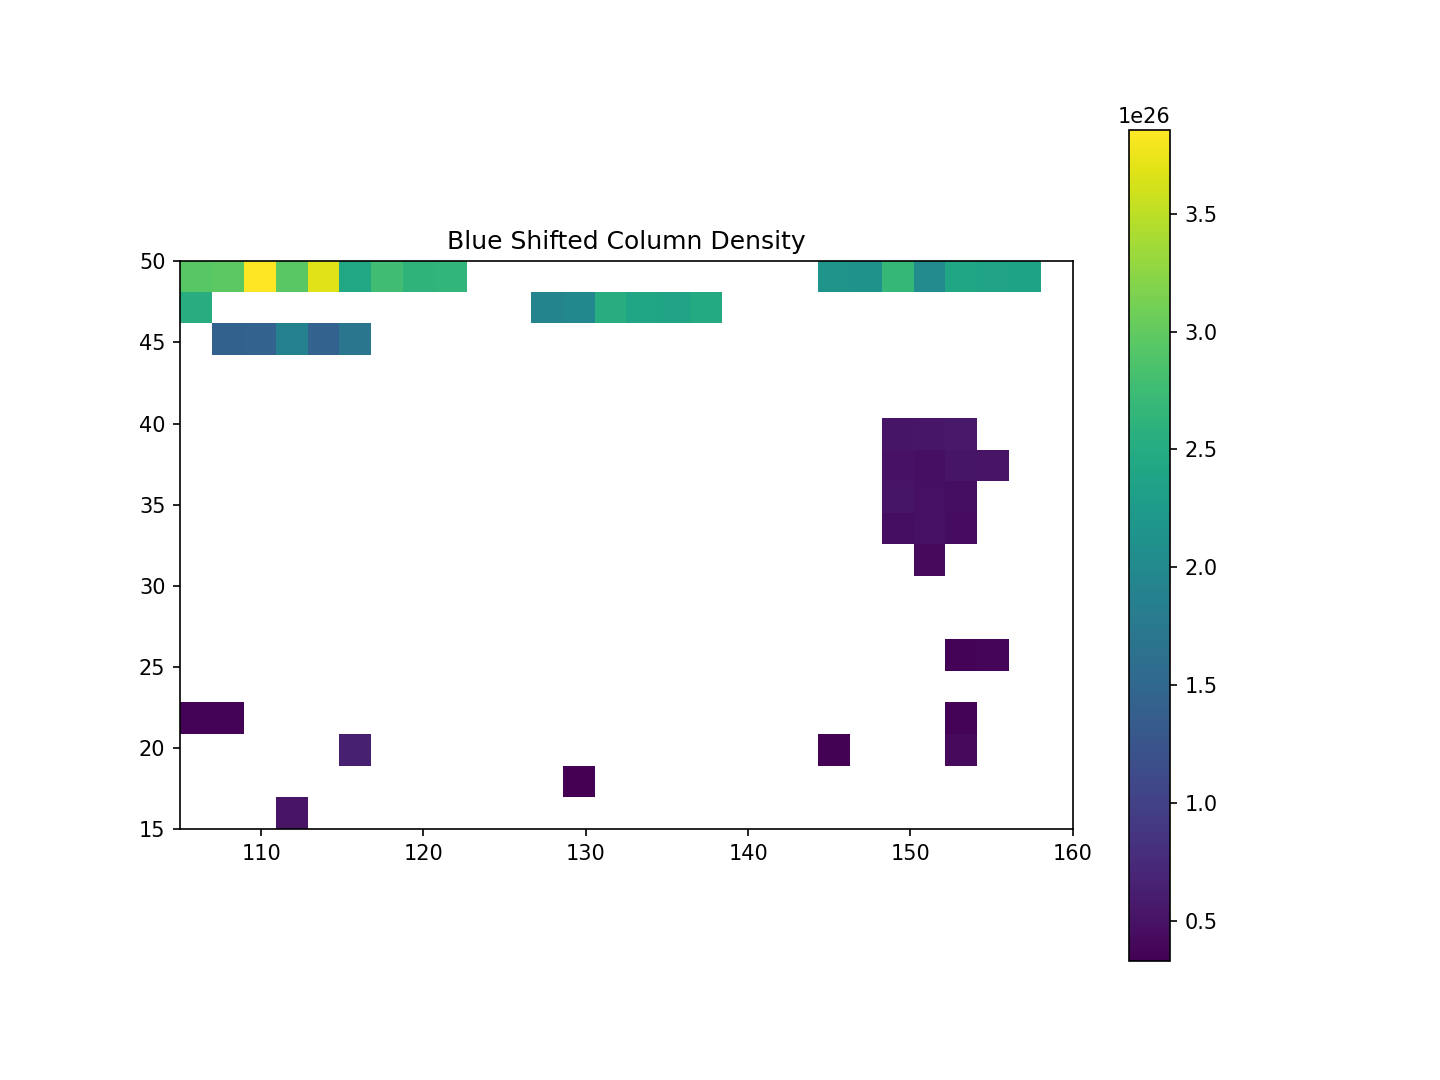

<IPython.core.display.Javascript object>


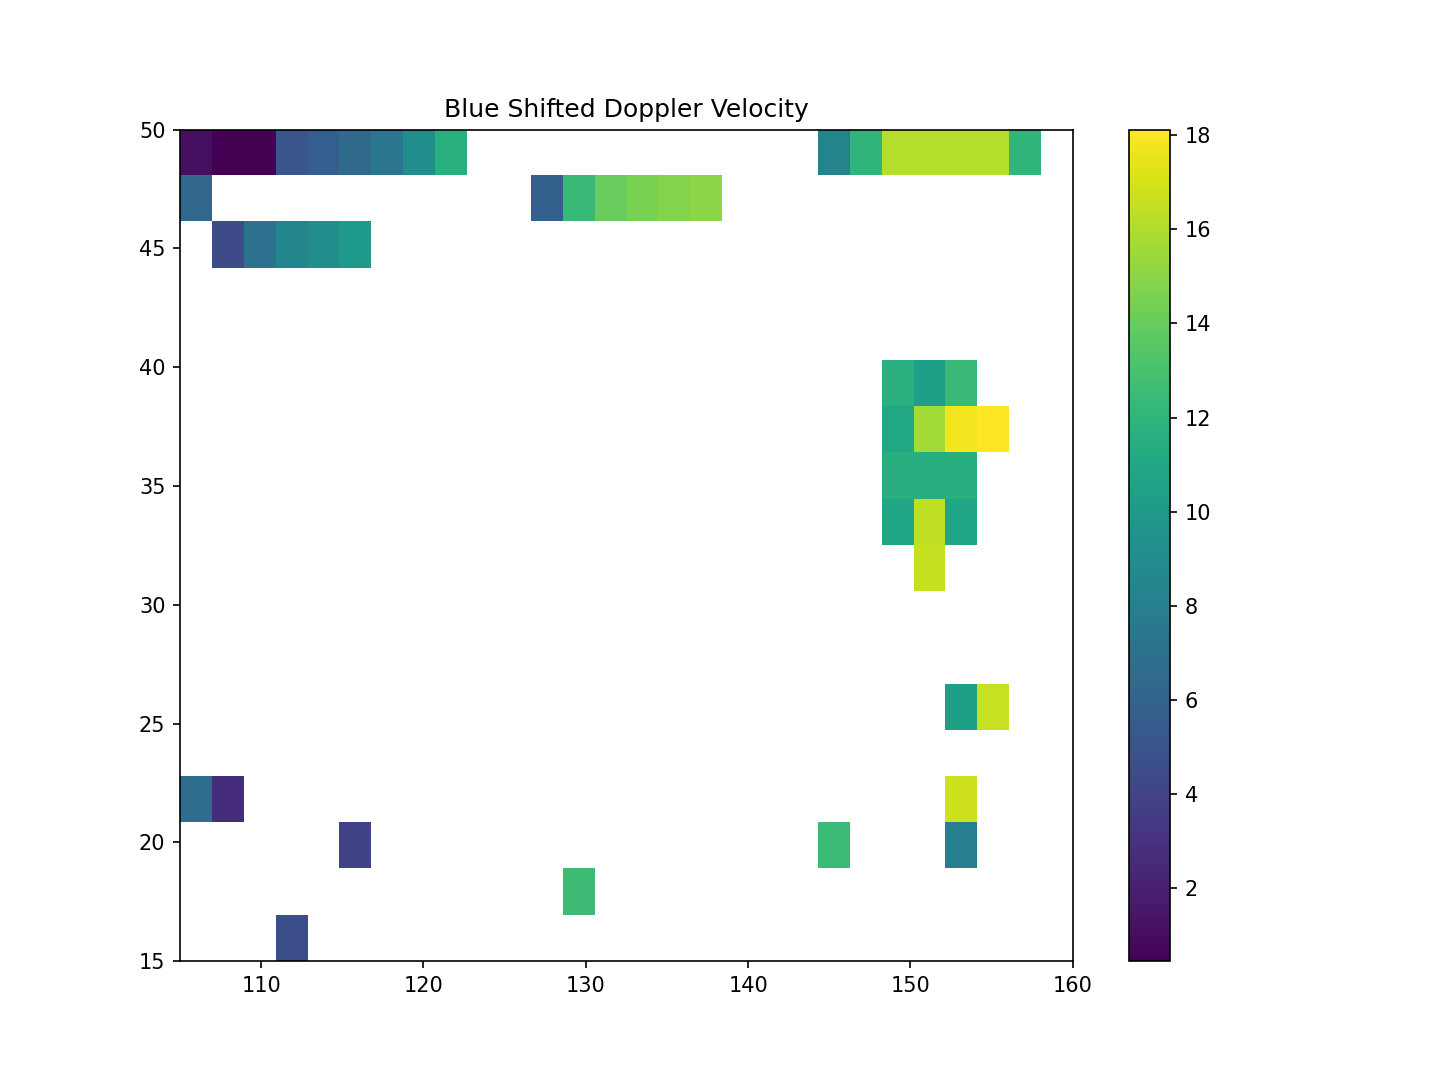

Text(0.5, 1.0, 'Blue Shifted Doppler Velocity')

In [116]:
plt.figure()
plt.imshow(blue_power_grid, extent=[105,160,15,50])
plt.colorbar()
plt.title('Blue Shifted Power')

plt.figure()
plt.imshow(blue_intensity_grid, extent=[105,160,15,50])
plt.colorbar()
plt.title('Blue Shifted Specific Intensity')

plt.figure()
plt.imshow(blue_column_density_grid, extent=[105,160,15,50])
plt.colorbar()
plt.title('Blue Shifted Column Density')

plt.figure()
plt.imshow(blue_doppler_velocity_grid, aspect='auto', extent=[105,160,15,50])
plt.colorbar()
plt.title('Blue Shifted Doppler Velocity')

## 6. Red Shifted : Create Dictionaries of Grid Values

In [117]:
# red shifts
f_0 = 1420.4e6 #Hz
c = 3e8 #m/s
k = 1.381e-23 #1.381e-16 cgs
nu_0 = 1420.405e6 #Mhz #hydrogen rest freq
nu = []
c = 3e8 #m/s

red_power_dict = {}
red_intensity_dict = {}
red_column_density_dict = {}
red_doppler_velocity_dict = {}

for i in calibrated_red_dictionary:
    #spectra already in temperature from calibrated
    #power = np.sum(spectra) #not meaningful, be careful, keep things in temp units. Take an average
    #power = np.mean(spectra[4270 : 4470])# fix this later # do different slices 
    
    spectra = calibrated_red_dictionary[i]
    power = np.mean(spectra)
    red_power_dict[i] = power

    #spectra_index = list(spectra).index(max(spectra))
    freq = rf_freq[index]*1e6 #[spectra_index]*1e6 #so it's in hertz
    #brightness_temp = spectra[spectra_index]
    intensity = spectra*2*k*freq**2/(c**2)
    
    #intensity = 2*freq**2*(1.381e-23)*brightness_temp/(c**2)# c is in seconds
    red_intensity_dict[i] = intensity
    
    v = freq*c/(2*f_0) *1e2 # doppler velocity, convert to cm/s
    delta_v = np.median(v[1:]-v[:-1]) #np.diff(v)
    column_density = abs(spectra)* delta_v * 1.8e18
    
    red_column_density_dict[i] = np.sum(column_density)
    
    spectra_index = list(spectra).index(max(spectra))
    new_freq = freq[spectra_index]
    delta_nu = new_freq - nu_0
    vel = delta_nu * c / nu_0
    ra = ra_dec_jd_dict[i][0]
    dec = ra_dec_jd_dict[i][1]
    jd = ra_dec_jd_dict[i][2]
    lsr_vel = ugradio.doppler.get_projected_velocity(ra, dec, jd)
    velocity = vel - abs(lsr_vel.value)
    red_doppler_velocity_dict[i] = velocity/1000

In [118]:
# create grids
red_power_grid = np.zeros((len(Ls),len(Bs)))
red_power_grid[:,] = np.nan
red_intensity_grid = np.zeros((len(Ls),len(Bs)))
red_intensity_grid[:,] = np.nan
red_column_density_grid = np.zeros((len(Ls),len(Bs)))
red_column_density_grid[:,] = np.nan
red_doppler_velocity_grid = np.zeros((len(Ls),len(Bs)))
red_doppler_velocity_grid[:,] = np.nan

for (L,B), spec in red_power_dict.items(): #items gives you the keys and the values
    red_power_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec

for (L,B), spec in red_intensity_dict.items(): #items gives you the keys and the values
    red_intensity_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec.max() #gives you a list of lists
    
for (L,B), spec in red_column_density_dict.items(): #items gives you the keys and the values
    red_column_density_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec.max() #gives you a list of lists
    
for (L,B), spec in red_doppler_velocity_dict.items(): #items gives you the keys and the values
    red_doppler_velocity_grid[np.argwhere(Ls == L)[0][0], np.argwhere(Bs==B)[0][0]] = spec #gives you a list of lists

<IPython.core.display.Javascript object>


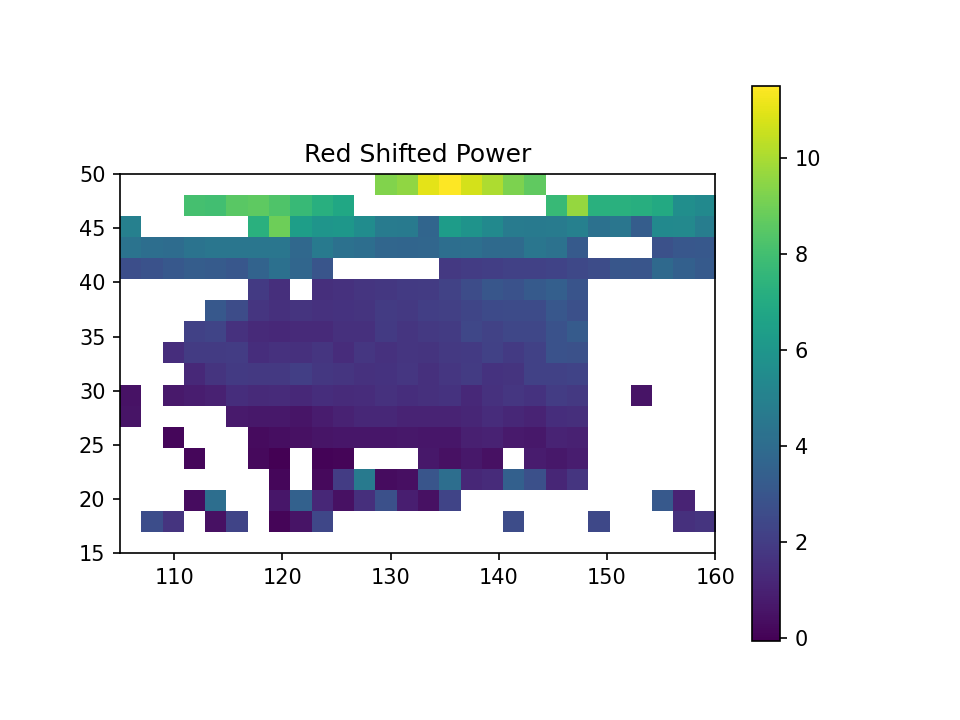

<IPython.core.display.Javascript object>


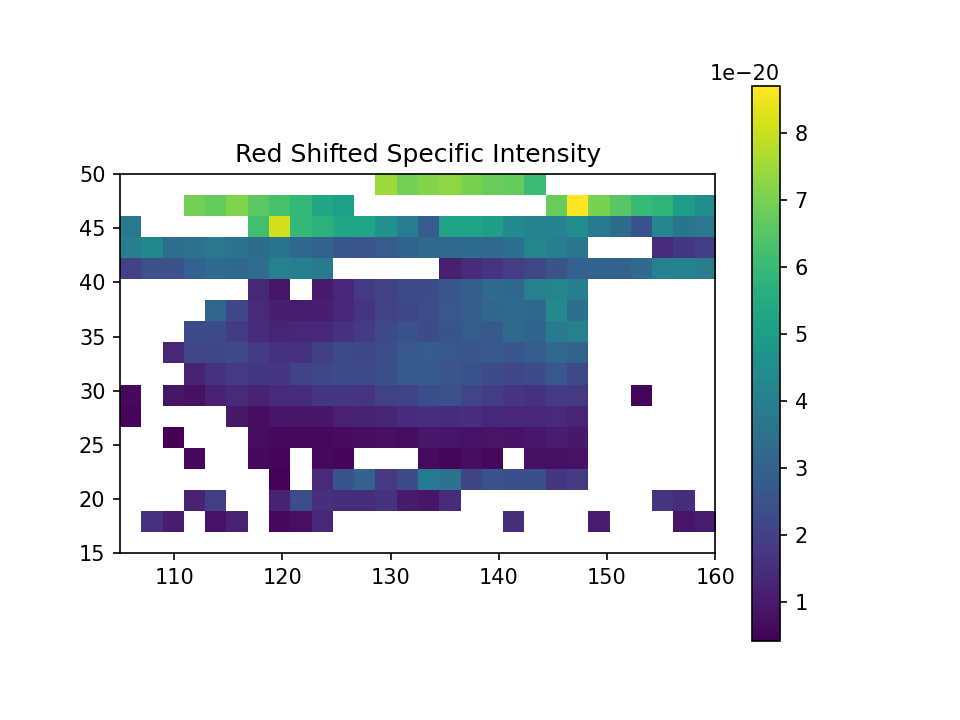

<IPython.core.display.Javascript object>


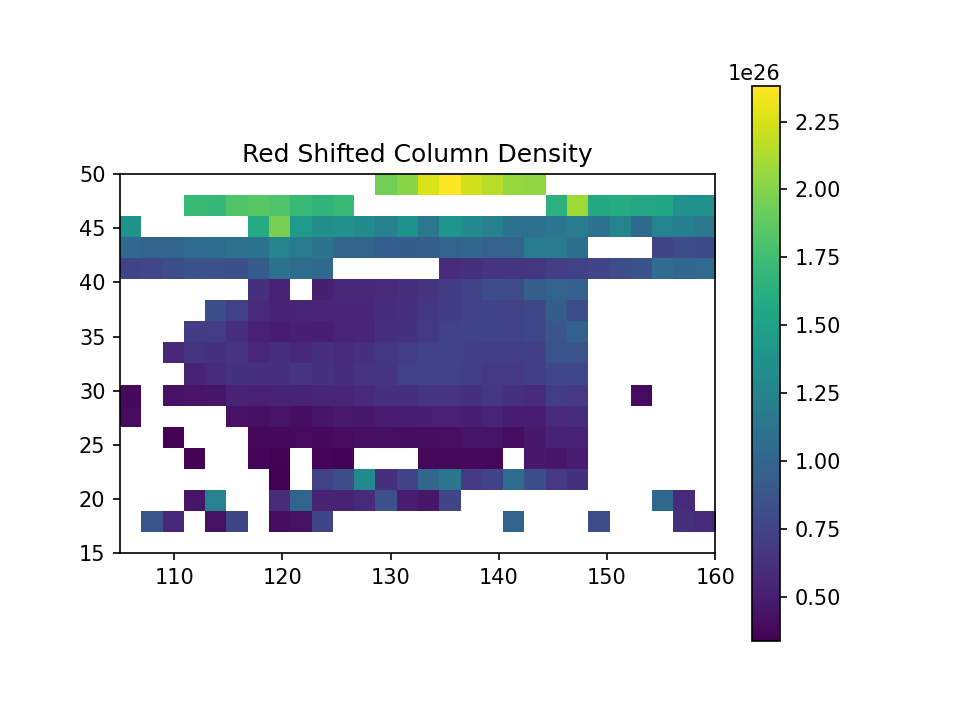

<IPython.core.display.Javascript object>


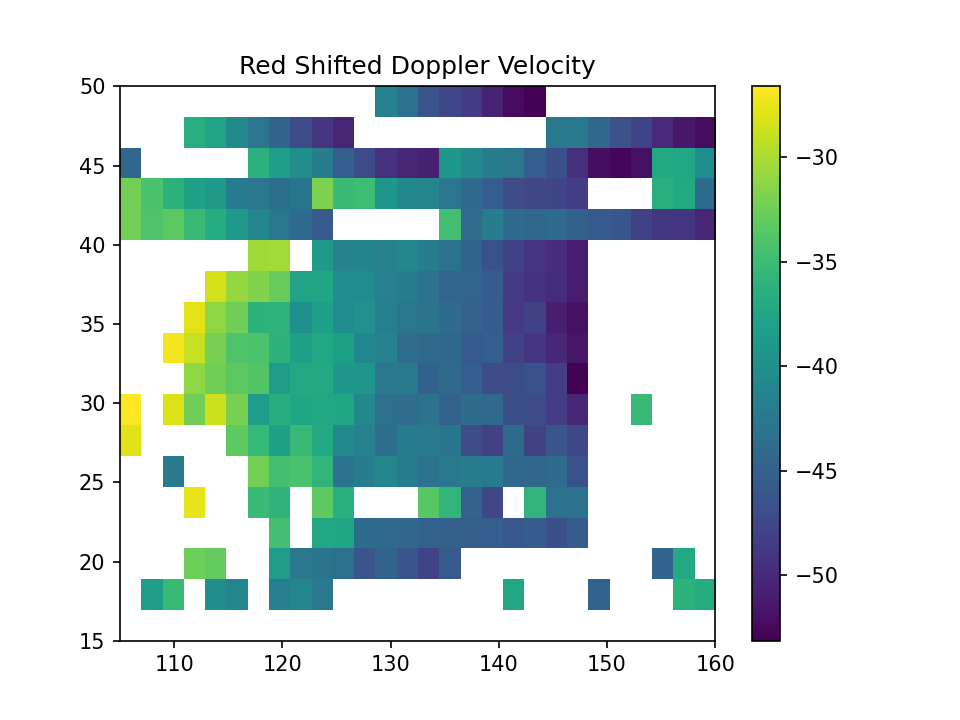

Text(0.5, 1.0, 'Red Shifted Doppler Velocity')

In [119]:
%matplotlib notebook
plt.figure()
plt.imshow(red_power_grid, extent=[105,160,15,50])
plt.colorbar()
plt.title('Red Shifted Power')

plt.figure()
plt.imshow(red_intensity_grid, extent=[105,160,15,50])
plt.colorbar()
plt.title('Red Shifted Specific Intensity')

plt.figure()
plt.imshow(red_column_density_grid, extent=[105,160,15,50])
plt.colorbar()
plt.title('Red Shifted Column Density')

plt.figure()
plt.imshow(red_doppler_velocity_grid, aspect='auto', extent=[105,160,15,50])
plt.colorbar()
plt.title('Red Shifted Doppler Velocity')

## Velocity Temp Graph

In [147]:
vt_dict_2.keys()

dict_keys([(-47.052358572297415, 139), (-38.477822293419436, 117), (-42.93752112168337, 123), (-13.39683697974237, 105), (-44.662285207735344, 149), (-38.82819107944086, 115), (-42.410792191865774, 147), (-32.073809947175654, 113), (-32.85429225830015, 141), (-9.112862710238353, 119), (-45.219472989719165, 139), (-37.47324282405385, 125), (-45.6019689233884, 135), (-44.61599035949462, 137), (-25.479682796457773, 115), (-39.86522138212975, 121), (-42.01445243194534, 123), (-35.212272989388, 121), (-37.6139382012101, 113), (-23.604953439759612, 107), (-26.964766728333192, 159), (-38.6029694517492, 119), (-48.3689207484109, 145), (-51.519437815439844, 147), (-16.182616694881453, 153), (-44.513319589971665, 135), (-46.49101796268276, 147), (-42.027765162887995, 139), (-44.80858753211435, 137), (-26.793547150006624, 151), (-42.38321237893273, 131), (-43.59349183071733, 129), (21.84672113258538, 145), (-49.947505766308694, 155), (-38.00647670805902, 121), (-30.055950349476888, 131), (36.9056

In [252]:
new_vt_dict = {}
for key, item in doppler_velocity_dict.items():
    new_key = (np.floor(item), key[1])
    new_vt_dict[new_key] = power_dict[key]

In [253]:
vels = list(set([key[0] for key in new_vt_dict.keys()]))
vels.sort()
vels = np.array(vels)

vt_grid = np.zeros((len(vels),len(Bs)))

#dict of key: (vel, long), item: temp

for (vel,B), temp in new_vt_dict.items(): #items gives you the keys and the values
    vt_grid[list(vels).index(vel), list(Bs).index(B)] = temp
    

In [255]:
vt_grid

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.22280684],
       [1.01606468, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

<IPython.core.display.Javascript object>


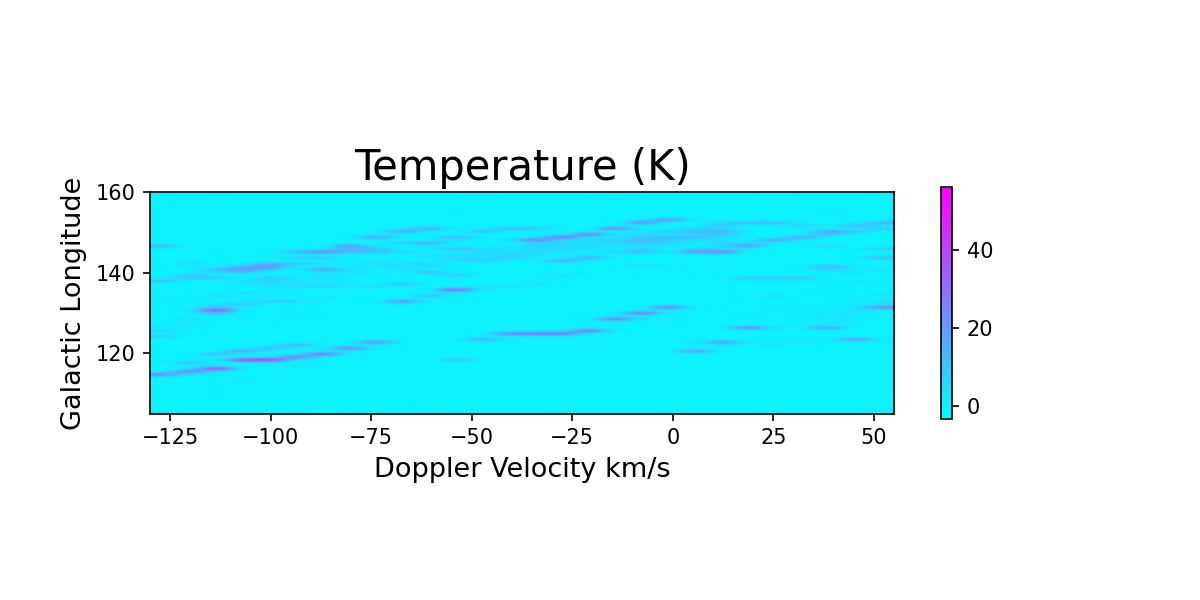

Text(0, 0.5, 'Galactic Longitude')

In [256]:
%matplotlib notebook
plt.figure(figsize=(8,4))
plt.imshow(vt_grid, extent=[-130, 55, 105, 160], cmap='cool', interpolation='gaussian')
plt.colorbar(shrink=.5)
plt.title('Temperature (K)', fontsize=20)
plt.xlabel('Doppler Velocity km/s', fontsize=13)
plt.ylabel('Galactic Longitude', fontsize=13)

## 7. Calculate Values

In [120]:
avg_power = np.mean(np.array(list(power_dict.values())))
avg_intensity = np.mean(np.array(list(intensity_dict.values())))
avg_column_density = np.mean(np.array(list(column_density_dict.values())))
avg_velocity = np.mean(np.array(list(doppler_velocity_dict.values())))

avg_red_power = np.mean(np.array(list(red_power_dict.values())))
avg_red_intensity = np.mean(np.array(list(red_intensity_dict.values())))
avg_red_column_density = np.mean(np.array(list(red_column_density_dict.values())))
avg_red_velocity = np.mean(np.array(list(red_doppler_velocity_dict.values())))

avg_blue_power = np.mean(np.array(list(blue_power_dict.values())))
avg_blue_intensity = np.mean(np.array(list(blue_intensity_dict.values())))
avg_blue_column_density = np.mean(np.array(list(blue_column_density_dict.values())))
avg_blue_velocity = np.mean(np.array(list(blue_doppler_velocity_dict.values())))

In [125]:
print("                             Total Values:")
print("length : " + str(len(np.array(list(power_dict.values())))))
print("avg_power : " + str(avg_power))
print("avg_intensity : " + str(avg_intensity))
print("avg_column_density : " + str(avg_column_density) + "  1/cm^2")
print("avg_velocity : " + str(avg_velocity) + "  km/s")

print("                             Blue Shift Values:")
print("length : " + str(len(np.array(list(blue_power_dict.values())))))
print("avg_power : " + str(avg_blue_power))
print("avg_intensity : " + str(avg_blue_intensity))
print("avg_column_density : " + str(avg_blue_column_density) + "  1/cm^2")
print("avg_velocity : " + str(avg_blue_velocity) + "  km/s")

print("                             Red Shift Values:")
print("length : " + str(len(np.array(list(red_power_dict.values())))))
print("avg_power : " + str(avg_red_power))
print("avg_intensity : " + str(avg_red_intensity))
print("avg_column_density : " + str(avg_red_column_density) + "  1/cm^2")
print("avg_velocity : " + str(avg_red_velocity) + "  km/s")

                             Total Values:
length : 474
avg_power : 2.696132348807216
avg_intensity : 1.6693200825687859e-21
avg_column_density : 8.502207725213949e+25  1/cm^2
avg_velocity : -32.54091594995144  km/s
                             Blue Shift Values:
length : 52
avg_power : 5.118012473408377
avg_intensity : 3.1692847828661817e-21
avg_column_density : 1.5046296011959958e+26  1/cm^2
avg_velocity : 10.54689263290472  km/s
                             Red Shift Values:
length : 293
avg_power : 2.7441326117014517
avg_intensity : 1.6989331247603564e-21
avg_column_density : 8.258760969492617e+25  1/cm^2
avg_velocity : -41.641754533515076  km/s


## 8. Calculate Error Values

In [129]:
def gauss(x, amp, std, mean):
    return amp*np.exp(-(x-mean)**2/(std**2)) 
def chisq(ys, mdl, sig):
    return np.sum(np.abs(ys-mdl)**2/sig**2)

<IPython.core.display.Javascript object>


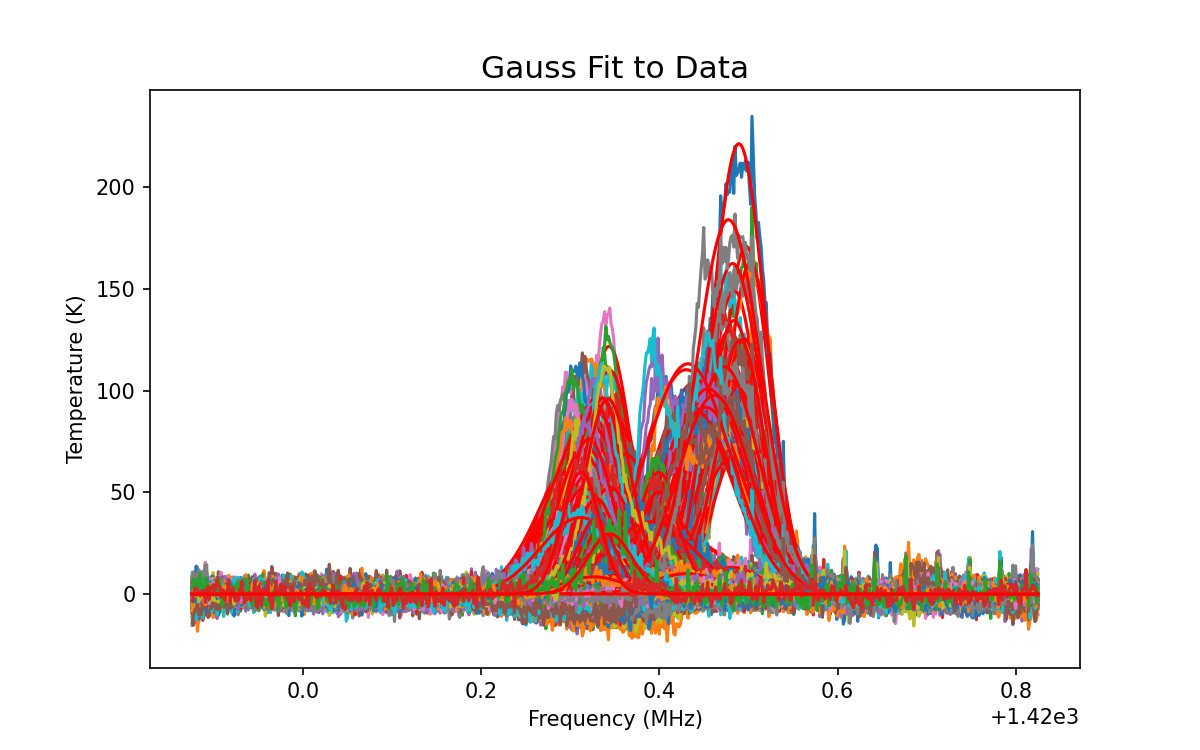

In [131]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
plt.title('Gauss Fit to Data', fontsize=15)

covariance_matrices = {}
parameters = {}
chisquared = {}
sigmas = {}
freq_cal = rf_freq[4000:4650]

for key in calibrated_noise_off_dictionary:
    
    spectra = calibrated_noise_off_dictionary[key]
    
    index = np.where((rf_freq > rf_freq[4000]) & (rf_freq < rf_freq[4650]))[0]
    
    amp2 = np.max(spectra)
    avg2 = 1420.4 #freq_cal[list(spectra).index(np.max(spectra))]
    sig2 = rf_freq[4470]-rf_freq[4270]
    d = {'amp' : amp2, 'avg':avg2, 'sig': sig2}
    p0 = [amp2, sig2, avg2]
    
    gauss_fit, covariance_matrix = optimize.curve_fit(gauss, rf_freq[index], spectra, p0=p0, bounds=[[0, 0, 1420.1],[300, 300, 1420.6]]) 
    parameters[key] = gauss_fit
    
    covariance_matrices[key] = (covariance_matrix)
    gauss_val = gauss(rf_freq[index], *gauss_fit)
    
    sigma = np.std(spectra[0:100])
    
    sigmas[key] = sigma
    chisquared[key] = chisq(spectra, gauss_val, sigma)
    
    #plt.axvline(rf_freq[4270], color='dodgerblue')
    #plt.axvline(rf_freq[4470], color='dodgerblue')
    
    #plt.plot(rf_freq[index][274:470], spectra, label='Data')
    plt.plot(rf_freq[index], spectra, label='Data')
    plt.plot(rf_freq[index], gauss_val, 'r', label='Fit')

In [257]:
amp_winners = {}
std_winners = {}
mean_winners = {}


for p in tqdm.tqdm(parameters):
    
    spectra = calibrated_noise_off_dictionary[p]
    
    amp_chisq = []
    std_chisq = []
    mean_chisq = []
    
    amp, std, mean = parameters[p]
    amps = np.linspace(amp-8, amp+8, 5000)
    stds = np.linspace(std-.5, std+.5, 5000)
    means = np.linspace(mean-.5, mean+.5, 5000)

    for amp_1 in amps:
        amp_chisq.append(chisq(spectra, gauss(rf_freq[index], amp_1, std, mean), sigmas[p]))
        
    for std_1 in stds:
        std_chisq.append(chisq(spectra, gauss(rf_freq[index], amp, std_1, mean), sigmas[p]))
        
    for mean_1 in means:
        mean_chisq.append(chisq(spectra, gauss(rf_freq[index], amp, std, mean_1), sigmas[p]))
        
    amp_chisq = np.array(amp_chisq)
    amp_winner = amps[np.argmin(np.abs(amp_chisq - chisquared[p] - 1))] 
    amp_winners[p] = abs(amp_winner)
    
    std_chisq = np.array(std_chisq)
    std_winner = stds[np.argmin(np.abs(std_chisq - chisquared[p] - 1))] 
    std_winners[p] = abs(std_winner)
    
    mean_chisq = np.array(mean_chisq)
    mean_winner = means[np.argmin(np.abs(mean_chisq - chisquared[p] - 1))] 
    mean_winners[p] = abs(mean_winner)

100%|██████████| 474/474 [04:06<00:00,  1.92it/s]


In [258]:
overall_amp_uncertainty = (1/(np.sum(1/np.array(list(amp_winners.values()))**2)))**(.5)
overall_avg_uncertainty = (1/(np.sum(1/np.array(list(mean_winners.values()))**2)))**(.5)
overall_std_uncertainty = (1/(np.sum(1/np.array(list(std_winners.values()))**2)))**(.5)

In [259]:
overall_amp_uncertainty

0.2727314479488635

In [260]:
overall_avg_uncertainty

65.24006243793663

In [261]:
overall_std_uncertainty

0.0017709774924806949